#INFO
an attempt to extract the roi mask as a YOLO format annotation text file
as we as changing the image format into png instead of jpeg , and saving it to google drive.
 


Importing google drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing dataset from kaggle

In [2]:
!pip install -q kaggle

In [4]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dnnbreastcancer","key":"33e6cf853cd6597e98d848c0a11e6f82"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset -p /content/ --unzip

100% 4.94G/4.95G [00:56<00:00, 134MB/s]
100% 4.95G/4.95G [00:57<00:00, 93.0MB/s]


imports

In [13]:
from skimage.draw import polygon
import plistlib
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import pandas as pd
import cv2

In [14]:
DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"
studies = pd.read_csv(f'{DDSM_dir}/csv_mod/studies.csv')

#dropping rows that doesn't have ROI mask.
studies.dropna(subset = ['ROI_path'],inplace = True)
studies.info()

studies['mammogram_path']=studies.apply(lambda x: x['mammogram_path'].replace(DDSM_dir, '/content'),axis=1)
studies['ROI_path']=studies.apply(lambda x: x['ROI_path'].replace(DDSM_dir, '/content'),axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3568 entries, 0 to 3603
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3568 non-null   int64 
 1   StudyNo         3568 non-null   int64 
 2   M_ID            3568 non-null   object
 3   P_ID            3568 non-null   object
 4   mammogram_path  3568 non-null   object
 5   ROI_path        3568 non-null   object
 6   cropped_path    3568 non-null   object
 7   pathology       3568 non-null   object
dtypes: int64(2), object(6)
memory usage: 250.9+ KB


#Converting yolo format

function difinition that gives a mask in yolo formate as well as it's text annotation 

In [15]:
output_dir_mams = "/content/yolo_data/images"
output_dir_masks = "/content/yolo_data/bbx"
output_dir_annotation = "/content/yolo_data/bbx_text"

os.makedirs(output_dir_mams)
os.makedirs(output_dir_masks)
os.makedirs(output_dir_annotation)

In [19]:
def mask_to_yolo(image,mask):
  rows, cols = np.where(mask>0)[0], np.where(mask>0)[1]

  # taking the min and max out of each polygon mask
  xmin = np.min(cols) 
  xmax = np.max(cols) 
  ymin = np.min(rows) 
  ymax = np.max(rows) 

  #drawing bounding box around the original image
  color=(0, 255, 255) # red
  yolo_mask = cv2.rectangle(image, (xmin,ymin ), (xmax, ymax), color, 2) #thickness = 1


  #returning the text file
  im_height, im_width = image.shape[:2]
  x_center = (xmin + xmax) / 2 / im_width
  y_center = (ymin + ymax) / 2 / im_height
  width = (xmax - xmin) / im_width
  height = (ymax - ymin) / im_height

  yolo_txt = f"0 {x_center} {y_center} {width} {height}" #text format

  return yolo_txt , yolo_mask 

##Sample

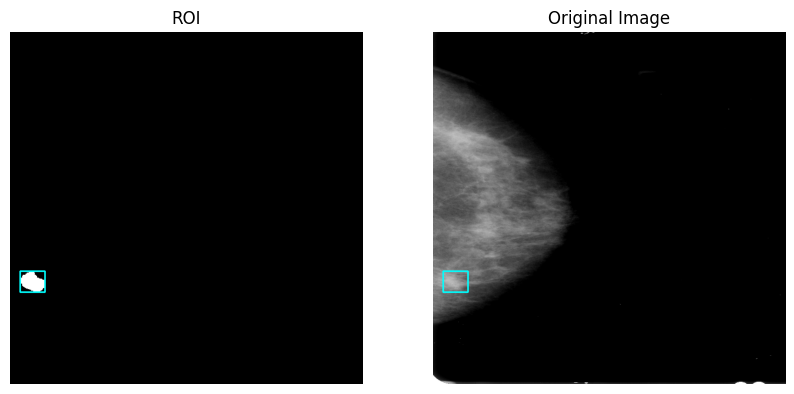

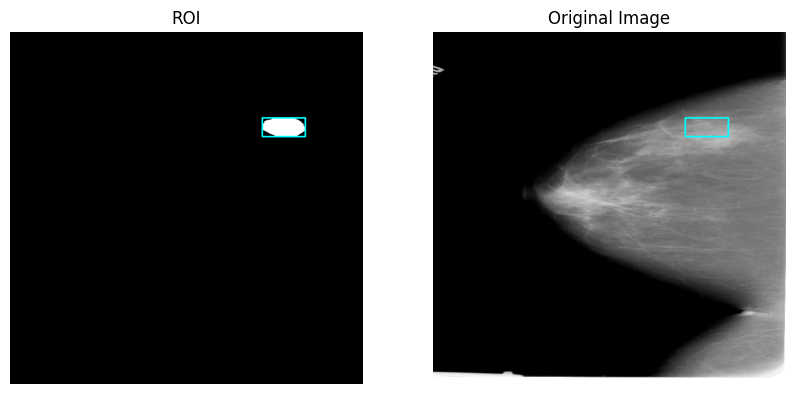

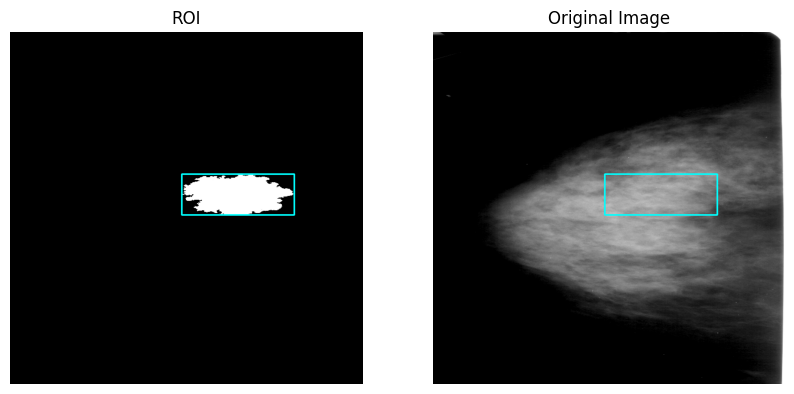

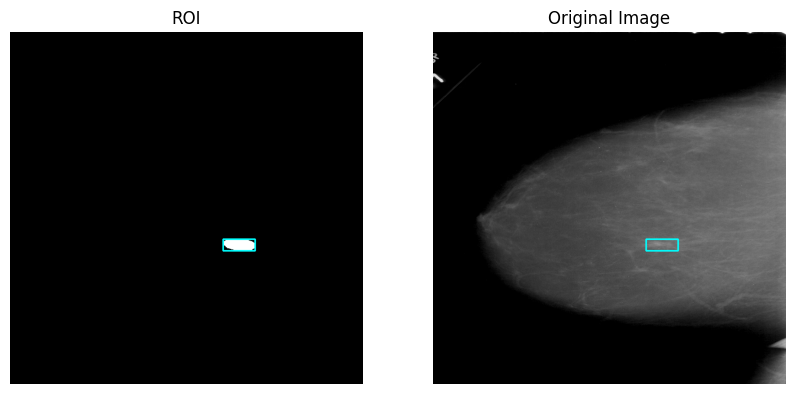

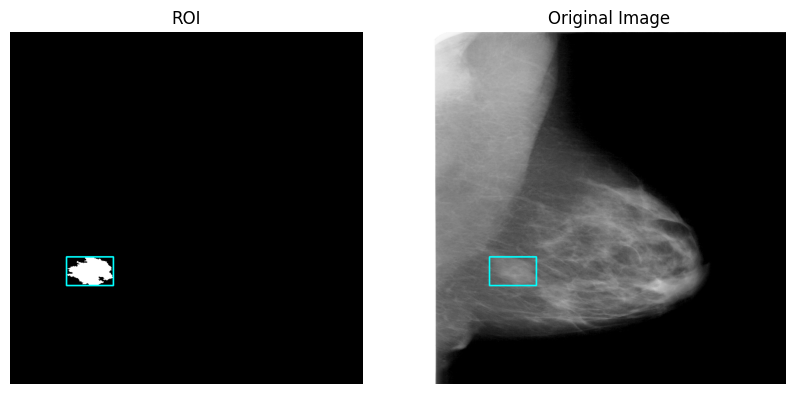

In [21]:
SIZE = (640,640)

yolo_masks = os.listdir(output_dir_masks)

df_smaple = studies.sample(n = 5)

for idx,sample in df_smaple.iterrows():

  img = cv2.resize(cv2.imread(sample['mammogram_path']),SIZE)

  mask = cv2.resize(cv2.imread(sample['ROI_path']),SIZE)

  mask_to_yolo(img,mask)[1] # by passingg the mask this function will draw the box on the mask

  mask_to_yolo(mask,mask)

  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  axs[0].imshow(mask, cmap='gray')
  axs[0].set_title("ROI")

  # Plot original image
  axs[1].imshow(img, cmap='gray')
  axs[1].set_title("Original Image")




  # Hide the axes
  for ax in axs:
    ax.axis('off')

  plt.show()

##Loop

In [ ]:
for index , row in tqdm(studies.iterrows()):
  mam_path = row['mammogram_path']
  M_ID = row['M_ID']
  roi_path = row['ROI_path']

  SIZE = (640,640) #yolo usually takes a multiples of 32

  # Save as PNG
  img = cv2.imread(mam_path)
  img = cv2.resize(img, SIZE)
  cv2.imwrite(f'{output_dir_mams}/{M_ID}.png', img)


  #yolo format
  msk = cv2.imread(roi_path)
  msk = cv2.resize(msk,SIZE)
  yolo_txt, yolo_mask = mask_to_yolo(img,msk)

  #saving the bbx mask
  cv2.imwrite(f'{output_dir_masks}/{M_ID}_bbx.png',yolo_mask)

  #saving the yolo annotation
  with open(f"{output_dir_annotation}/{M_ID}.txt", 'w') as f:
    line = ' '.join(map(str, yolo_txt)) + '\n'
    f.write(line)

saving copying files into drive

In [ ]:
!cp -R "/content/yolo_data" "/content/drive/MyDrive"

In [ ]:
!cp -r "/content/yolo_data/bbx" "/content/drive/MyDrive/yolo_data"

In [ ]:
!cp -r "/content/yolo_data/bbx_text" "/content/drive/MyDrive/yolo_data"